# ***XG-Boost***

In [1]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

import os
import random
import time
import joblib
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis

import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)
from sklearn.utils.class_weight import compute_sample_weight
import lime.lime_tabular
import time

from model_evaluator import ModelEvaluator
me = ModelEvaluator([0,1,2])
from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
# LOAD DATA
file_path = "../Preprocessed_data.xlsx"
df = pd.read_excel(file_path)
X = df.drop(columns=["Cuenta", "Estado", "ID"])
y = df["Estado"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
# FILE PATHS
model_filename = "../Models/best_xgb_model.pkl"
study_filename = "../Study/optuna_study_XGB_nested.pkl"
metrics_filename = "../Models/best_xgb_metrics.pkl"
fold_metrics_filename = "./Metrics/xgb_folds_summary.csv"

In [4]:
class XGBWrapper:
    def __init__(self, params, numeric_features, categorical_features):
        self.params = params.copy()
        self.num_boost_round = self.params.pop("num_boost_round")
        self.early_stopping_rounds = self.params.pop("early_stopping_rounds", None)
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.preprocessor = self._build_preprocessor()
        self.model = None
        self.evals_result = None
        self.best_iteration = None
        self.best_score = None

    def _build_preprocessor(self):
        return ColumnTransformer(
            transformers=[
                ('num', SimpleImputer(strategy='median'), self.numeric_features),
                ('cat', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                ]), self.categorical_features)
            ],
            verbose_feature_names_out=False,
            force_int_remainder_cols=False
        )

    def fit(self, X, y, eval_set=None, sample_weight=None):
        self.preprocessor = self._build_preprocessor().fit(X)
        X_proc = self.preprocessor.transform(X)

        if sample_weight is not None:
            dtrain = xgb.DMatrix(X_proc, label=y, weight=sample_weight)
        else:
            dtrain = xgb.DMatrix(X_proc, label=y)

        evals = [(dtrain, "train")]
        evals_result = {}

        if eval_set is not None:
            X_val, y_val = eval_set[0]
            X_val_proc = self.preprocessor.transform(X_val)
            dval = xgb.DMatrix(X_val_proc, label=y_val)
            evals.append((dval, "validation"))

        train_params = {
            'params': self.params,
            'dtrain': dtrain,
            'num_boost_round': self.num_boost_round,
            'evals': evals,
            'evals_result': evals_result,
            'verbose_eval': False
        }

        if self.early_stopping_rounds is not None and len(evals) > 1:
            train_params['early_stopping_rounds'] = self.early_stopping_rounds

        print("=== PARAMS usados en entrenamiento ===")
        print(self.params)
        self.model = xgb.train(**train_params)
        self.evals_result = evals_result
        self.best_iteration = getattr(self.model, "best_iteration", None)
        self.best_score = getattr(self.model, "best_score", None)                           

        return self

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        dmatrix = xgb.DMatrix(X_proc)
        y_proba = self.model.predict(dmatrix)
        return np.argmax(y_proba, axis=1)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        dmatrix = xgb.DMatrix(X_proc)
        return self.model.predict(dmatrix)

    def save(self, path):
        joblib.dump({
            "params": self.params,
            "num_boost_round": self.num_boost_round,
            "early_stopping_rounds": self.early_stopping_rounds,
            "numeric_features": self.numeric_features,
            "categorical_features": self.categorical_features,
            "preprocessor": self.preprocessor,
            "booster": self.model,
            "best_iteration": self.best_iteration,
            "best_score": self.best_score
        }, path)

    @classmethod
    def load(cls, path):
        data = joblib.load(path)
        params = {**data["params"], "num_boost_round": data["num_boost_round"]}

        if "early_stopping_rounds" in data:
            params["early_stopping_rounds"] = data["early_stopping_rounds"]

        wrapper = cls(
            params,
            data["numeric_features"],
            data["categorical_features"]
        )
        wrapper.preprocessor = data["preprocessor"]
        wrapper.model = data["booster"]
        wrapper.best_iteration = data.get("best_iteration")
        wrapper.best_score = data.get("best_score")
        return wrapper


In [5]:
# OPTUNA INNER CV OPTIMIZATION
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=50):
    def objective(trial):
        params = {
            "verbosity": 0,
            "objective": "multi:softprob",
            "num_class": len(np.unique(y_inner)),
            "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
            "max_depth": trial.suggest_int("max_depth", 4, 10), #8
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1), #0.01
            "tree_method": "hist",
            "device": "cuda",
            "seed": SEED,
            "num_boost_round": trial.suggest_int("num_boost_round", 50, 300), #250
            "early_stopping_rounds": 15
        }

        # Extra dropout config if booster is dart
        if params["booster"] == "dart":
            params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            params["rate_drop"] = trial.suggest_float("rate_drop", 0.1, 0.5)
            params["skip_drop"] = trial.suggest_float("skip_drop", 0.0, 0.5)
        
        model = XGBWrapper(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []
        
        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            
            sample_weights = compute_sample_weight("balanced", y_t)
            
            eval_set = [(X_v, y_v)]
            
            model.fit(X_t, y_t, eval_set=eval_set, sample_weight=sample_weights)
            
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))
        
        return np.mean(scores)
    
    pruner = MedianPruner()
    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=n_trials, n_jobs=10)
    
    return study.best_params, study

In [ ]:
# NESTED CV
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(
        enumerate(outer_cv.split(X, y), 1),
        total = outer_cv.get_n_splits(),
        desc="Training folds"
    ):
        
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]
    
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold,
            test_size=0.2, stratify=y_train_fold, random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time

        optuna_studies.append(study)

        model = XGBWrapper(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = me.evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = me.evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = me.evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }
            
    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = me.save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations

In [7]:
# Run pipeline
categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)

In [8]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      3426
           1       0.83      0.74      0.78      1034
           2       0.83      0.72      0.77       625

    accuracy                           0.89      5085
   macro avg       0.86      0.81      0.83      5085
weighted avg       0.89      0.89      0.89      5085



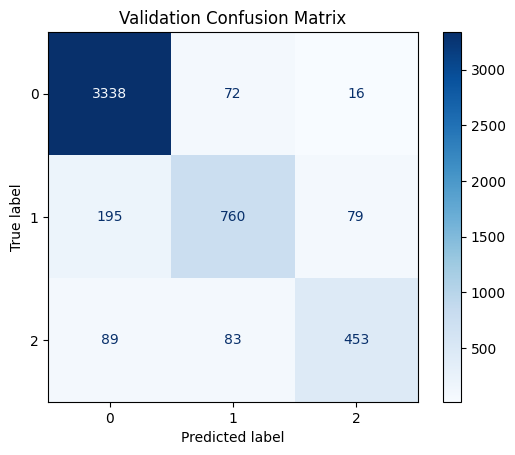

In [9]:
me.plot_confusion_matrix(metrics['confusion_matrix_val'], "Validation Confusion Matrix")

In [10]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4282
           1       0.80      0.74      0.77      1293
           2       0.81      0.72      0.76       781

    accuracy                           0.89      6356
   macro avg       0.84      0.81      0.82      6356
weighted avg       0.88      0.89      0.89      6356



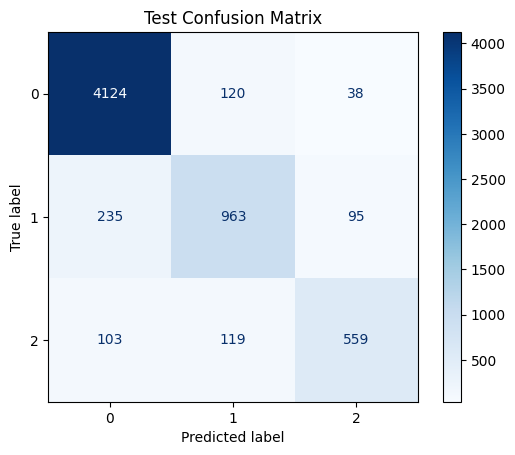

In [11]:
me.plot_confusion_matrix(metrics['confusion_matrix_test'], "Test Confusion Matrix")

In [12]:
def plot_loss_curves(model):
    """
    Plots train and validation log loss over boosting rounds.
    Adds a vertical line at the best_iteration if available.
    """
    if not hasattr(model, "evals_result"):
        raise ValueError("The model has no evaluation history.")

    results = model.evals_result
    for dataset in results:
        if "mlogloss" in results[dataset]:
            plt.plot(results[dataset]["mlogloss"], label=f"{dataset} logloss")

    plt.xlabel("Boosting round")
    plt.ylabel("Log loss")
    plt.title("Log loss - train vs validation")
    plt.legend()
    plt.grid(True)

    if hasattr(model, "best_iteration") and model.best_iteration is not None:
        plt.axvline(x=model.best_iteration, color="red", linestyle="--", label="Best iteration")
        plt.legend()

    plt.show()


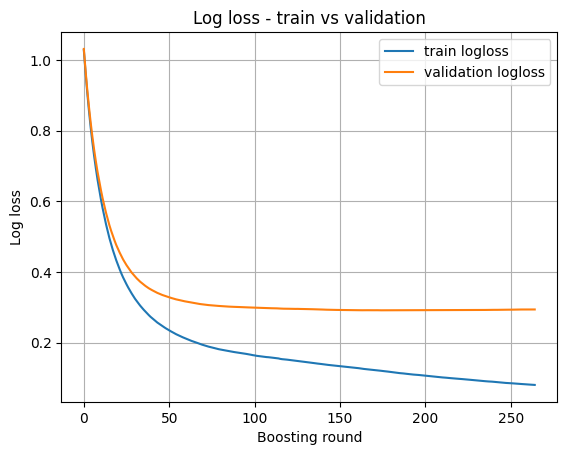

In [13]:
plot_loss_curves(model)

--- Explanation for class 0 ---


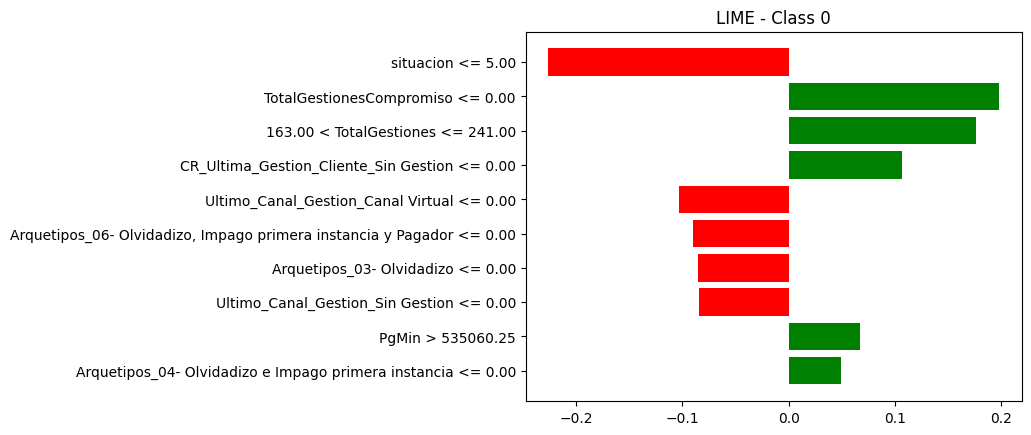

--- Explanation for class 1 ---


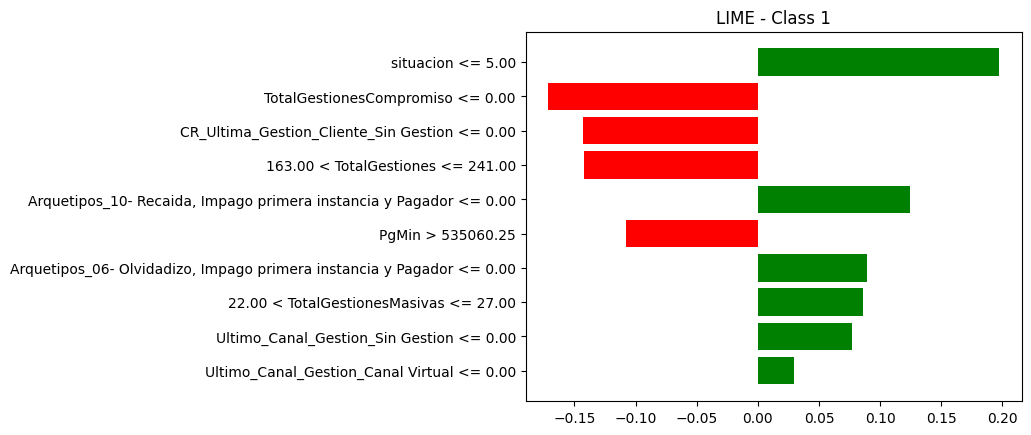

--- Explanation for class 2 ---


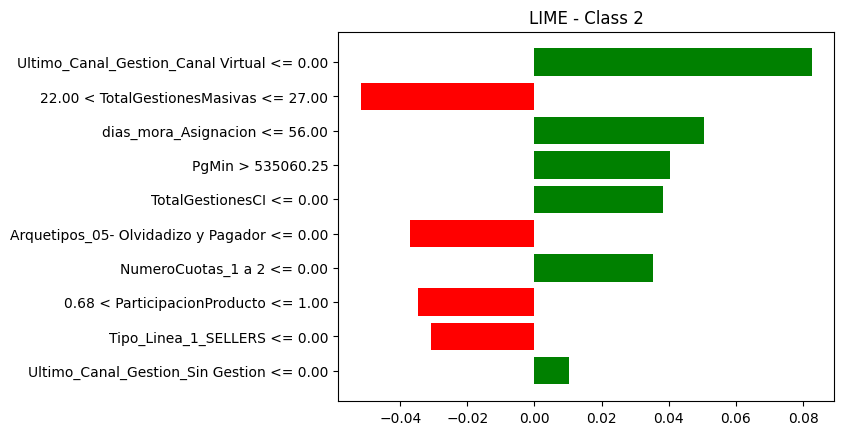

In [14]:
X_transformed = model.preprocessor.transform(metrics['X_train_fold'])

def predict_fn(x):
    dmatrix = xgb.DMatrix(x)
    return model.model.predict(dmatrix)

feature_names = model.preprocessor.get_feature_names_out()
class_names = np.unique(metrics['y_train_fold']).astype(str)

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

instance = X_transformed[10]
exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])

exp.show_in_notebook(show_table=True)

for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()


In [15]:
visualizations['optimization_history']

In [16]:
visualizations['parallel_coordinate']

In [17]:
visualizations['f1_score_evolution']

In [18]:
visualizations['param_importances']

In [19]:
raw_importances = model.model.get_score(importance_type='gain')

feature_names = model.preprocessor.get_feature_names_out()

mapped_importances = []
for i, fname in enumerate(feature_names):
    score = raw_importances.get(f"f{i}", 0)
    mapped_importances.append((fname, score))

importance_df = pd.DataFrame(mapped_importances, columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False).head(20)

fig = px.bar(
    importance_df,
    x='Feature',
    y='Importance',
    title='Top 20 Feature Importance - XGBoost',
    labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
    color='Importance',
    color_continuous_scale='Viridis',
    text='Importance'
)
fig.update_layout(xaxis_tickangle=45)
fig.show()


In [20]:
reporte.save(metrics, model_name="XGBOOST")


Report for model 'XGBOOST' saved:
   → CSV: ./Metrics/Metrics_XGBOOST.csv
   → JSON: ./Metrics/Metrics_XGBOOST.json


In [21]:
df = reporte.load()


Loaded 9 report(s)


In [22]:
df.query("Model == 'XGBOOST' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
114,XGBOOST,val,0,0.922,0.974,0.947
115,XGBOOST,val,1,0.831,0.735,0.78
116,XGBOOST,val,2,0.827,0.725,0.772
117,XGBOOST,val,macro avg,0.86,0.811,0.833
118,XGBOOST,val,weighted avg,0.891,0.895,0.892


In [23]:
df.query("Model == 'XGBOOST' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
120,XGBOOST,test,0,0.924,0.963,0.943
121,XGBOOST,test,1,0.801,0.745,0.772
122,XGBOOST,test,2,0.808,0.716,0.759
123,XGBOOST,test,macro avg,0.844,0.808,0.825
124,XGBOOST,test,weighted avg,0.885,0.888,0.886


In [25]:
df.query("Model == 'XGBOOST' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
119,XGBOOST,val,0.895,0.294,0.967


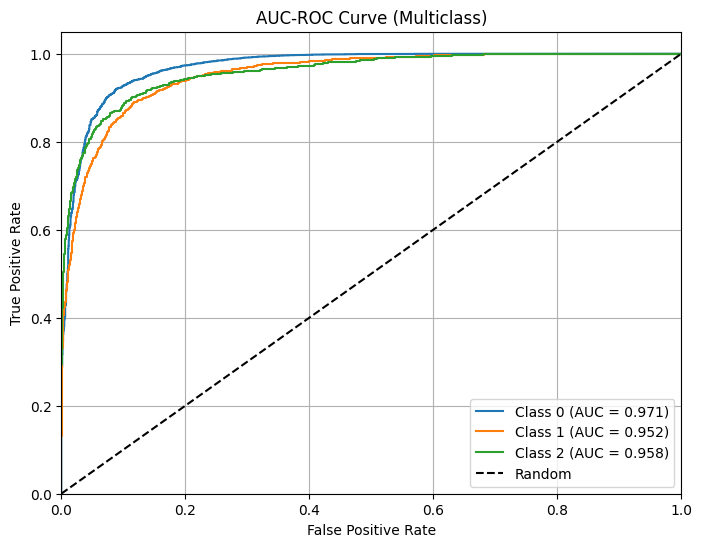

In [26]:
me.plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
)

In [27]:
model.params  

{'booster': 'gbtree',
 'lambda': 0.03166822355751029,
 'alpha': 0.19257431592978247,
 'subsample': 0.8007074778968828,
 'colsample_bytree': 0.9228734433228807,
 'colsample_bylevel': 0.908947608048496,
 'max_depth': 8,
 'min_child_weight': 4,
 'gamma': 0.029496581171187784,
 'learning_rate': 0.06695454122370971,
 'objective': 'multi:softprob',
 'num_class': 3,
 'tree_method': 'hist',
 'device': 'cuda',
 'verbosity': 0,
 'seed': 42}

In [28]:
metrics_xg_folds = pd.read_csv("Metrics/xgb_folds_summary.csv")
metrics_xg_folds

,fold,f1_val,accuracy_val,log_loss_val,auc_val,f1_test,accuracy_test,log_loss_test,auc_test,optuna_time
0,1,0.887,0.890,0.297,0.965,0.885,0.888,0.302,0.965,2571.892
1,2,0.892,0.895,0.294,0.967,0.886,0.888,0.300,0.966,2858.679
2,3,0.875,0.878,0.318,0.961,0.881,0.884,0.308,0.964,7176.086
3,4,0.887,0.890,0.302,0.964,0.884,0.888,0.299,0.967,4131.542
4,5,0.884,0.887,0.299,0.966,0.881,0.885,0.320,0.959,7109.919
5,mean,0.885,0.888,0.302,0.965,0.883,0.886,0.306,0.964,4769.624
6,std,0.006,0.006,0.009,0.003,0.002,0.002,0.009,0.003,2244.823


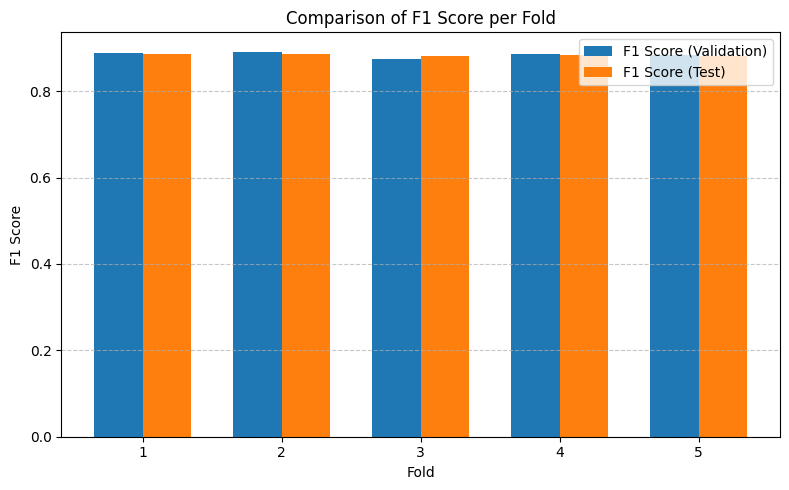

In [29]:
metrics_numeric = metrics_xg_folds[metrics_xg_folds["fold"].astype(str).str.isnumeric()].copy()
metrics_numeric["fold"] = metrics_numeric["fold"].astype(int)

# Bar plot: F1 Score Validation vs Test
plt.figure(figsize=(8, 5))
bar_width = 0.35
folds = metrics_numeric["fold"]
plt.bar(folds - bar_width/2, metrics_numeric["f1_val"], width=bar_width, label="F1 Score (Validation)")
plt.bar(folds + bar_width/2, metrics_numeric["f1_test"], width=bar_width, label="F1 Score (Test)")
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.title("Comparison of F1 Score per Fold")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

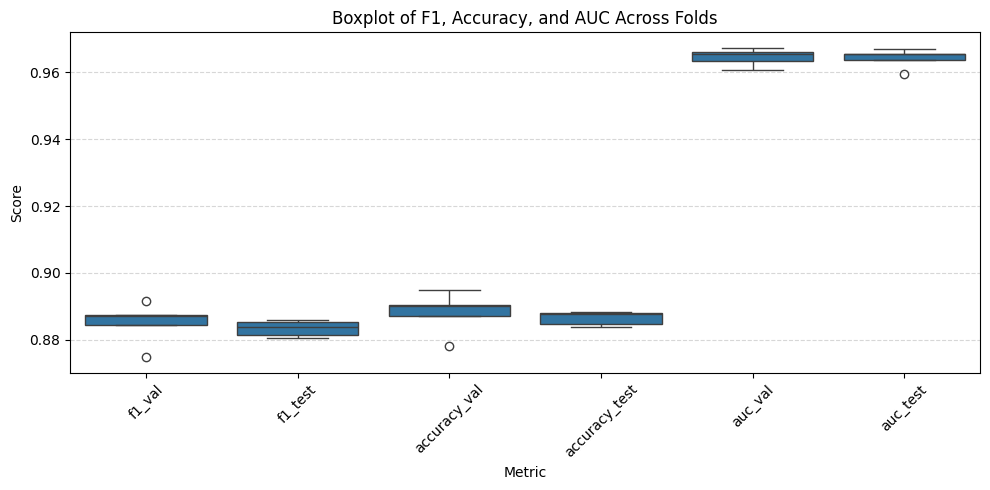

In [30]:
# Exclude log_loss metrics
metrics_main = metrics_numeric.melt(id_vars="fold", value_vars=[
    "f1_val", "f1_test", "accuracy_val", "accuracy_test", "auc_val", "auc_test"
])

plt.figure(figsize=(10, 5))
sns.boxplot(data=metrics_main, x="variable", y="value")
plt.xticks(rotation=45)
plt.title("Boxplot of F1, Accuracy, and AUC Across Folds")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()


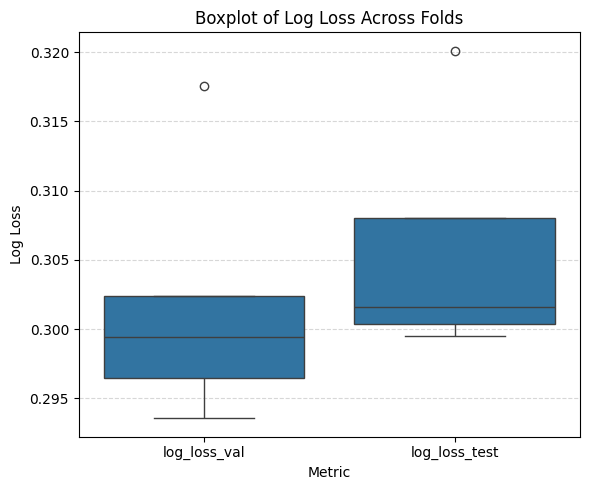

In [31]:
# Only log_loss metrics
metrics_logloss = metrics_numeric.melt(id_vars="fold", value_vars=[
    "log_loss_val", "log_loss_test"
])

plt.figure(figsize=(6, 5))
sns.boxplot(data=metrics_logloss, x="variable", y="value")
plt.title("Boxplot of Log Loss Across Folds")
plt.xlabel("Metric")
plt.ylabel("Log Loss")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()


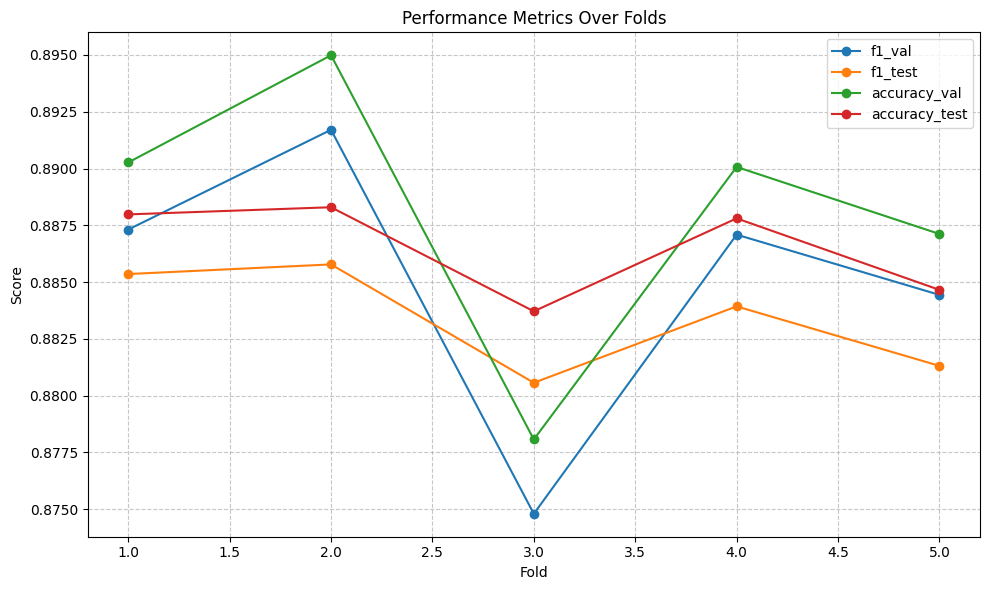

In [32]:
plt.figure(figsize=(10, 6))
for metric in ["f1_val", "f1_test", "accuracy_val", "accuracy_test"]:
    plt.plot(metrics_numeric["fold"], metrics_numeric[metric], marker='o', label=metric)

plt.title("Performance Metrics Over Folds")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()


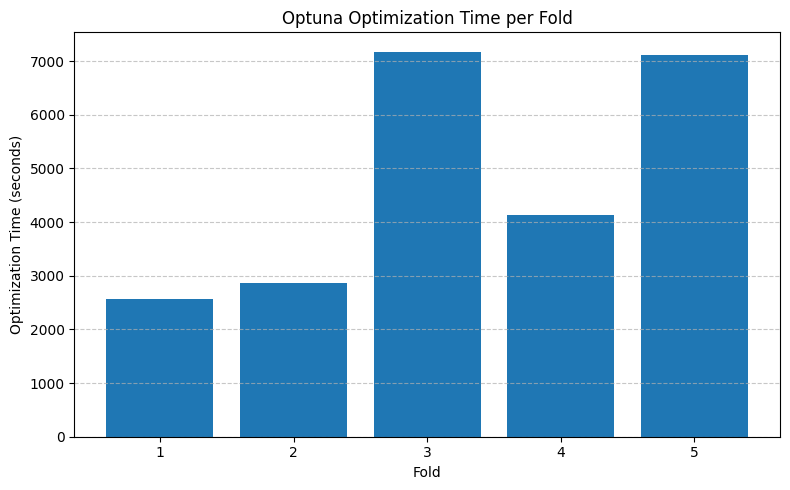

In [33]:
plt.figure(figsize=(8, 5))
plt.bar(metrics_numeric["fold"], metrics_numeric["optuna_time"])
plt.xlabel("Fold")
plt.ylabel("Optimization Time (seconds)")
plt.title("Optuna Optimization Time per Fold")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


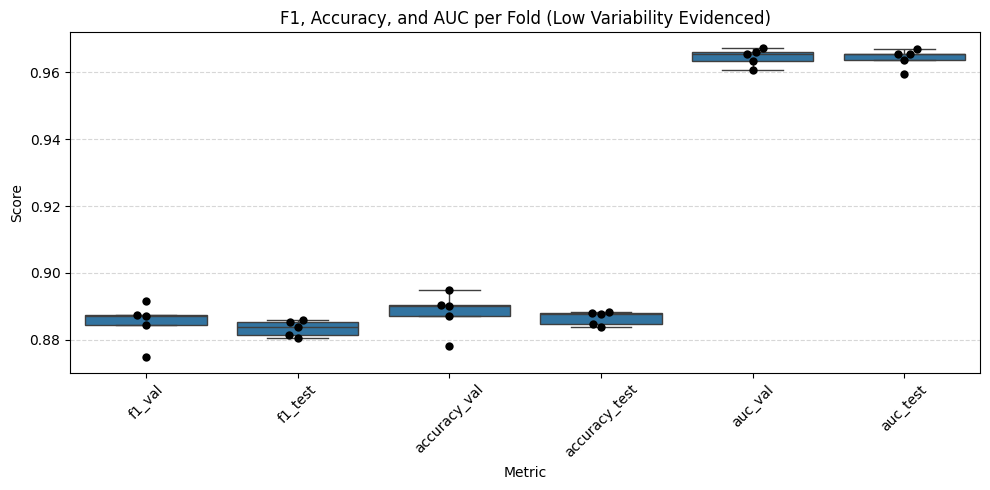

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=metrics_main, x="variable", y="value", showfliers=False)
sns.swarmplot(data=metrics_main, x="variable", y="value", color="black", size=6)
plt.xticks(rotation=45)
plt.title("F1, Accuracy, and AUC per Fold (Low Variability Evidenced)")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
